<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


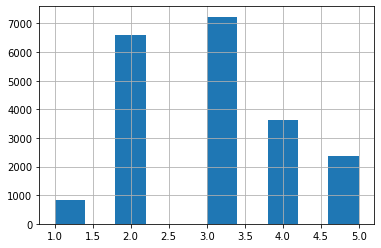

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipynb.fs.full.project_part_1 import strat_train_set

# Prepare the Data for Machine Learning Algorithms

It’s time to prepare the data for your Machine Learning algorithms. Instead of doing this manually, you should write functions for this purpose, for several good reasons:

        - This will allow you to reproduce these transformations easily on any dataset (e.g., the next time you get a fresh dataset).
        - You will gradually build a library of transformation functions that you can reuse in future projects.
        - You can use these functions in your live system to transform the new data before feeding it to your algorithms.
        - This will make it possible for you to easily try various transformations and see which combination of transformations works best.

But first let’s revert to a clean training set (by copying `strat_train_set` once again). Let’s also separate the **predictors** and the **labels**, since we don’t necessarily want to apply the same transformations to the predictors and the target values (note that **`drop()`** creates a copy of the data and does not affect **`strat_train_set`**):

In [5]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

## Data Cleaning

Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to take care of them. We saw earlier that the **`total_bedrooms`** attribute has some missing values, so let’s fix this. You have three options:

        1. Get rid of the corresponding districts.
        2. Get rid of the whole attribute.
        3. Set the values to some value (zero, the mean, the median, etc.).

You can accomplish these easily using DataFrame’s **`dropna()`**, **`drop()`**, and **`fillna()`** methods:

In [3]:
housing.dropna(subset=['total_bedrooms'])   # Option 1
housing.drop('total_bedrooms', axis=1)      # Option 2
median = housing['total_bedrooms'].median() # Option 3
housing['total_bedrooms'].fillna(median, inplace=True)

If you choose option 3, you should compute the median value on the training set and use it to fill the missing values in the training set. Don’t forget to save the median value that you have computed. You will need it later to replace missing values in the test set when you want to evaluate your system, and also once the system goes live to replace missing values in new data.

Scikit-Learn provides a handy class to take care of missing values: **`SimpleImputer`**. Here is how to use it. First, you need to create a **`SimpleImputer`** instance, specifying that you want to replace each attribute’s missing values with the median of that attribute:

In [6]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

Since the median can only be computed on numerical attributes, you need to create a copy of the data without the text attribute **`ocean_proximity`**:

In [7]:
housing_num = housing.drop('ocean_proximity', axis=1)

Now you can fit the **`imputer`** instance to the training data using the **`fit()`** method:

The **`imputer`** has simply computed the median of each attribute and stored the result in its **`statistics_`** instance variable. Only the **`total_bedrooms`** attribute had missing values, but we cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the imputer to all the numerical attributes:

In [9]:
imputer.fit(housing_num)

imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [10]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Now you can use this “trained” **`imputer`** to transform the training set by replacing missing values with the learned medians:

In [7]:
X = imputer.transform(housing_num)

The result is a plain NumPy array containing the transformed features. If you want to put it back into a pandas DataFrame, it’s simple:

In [8]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = housing_num.index)

## Handling Text and Categorical Attributes

So far we have only dealt with numerical attributes, but now let’s look at text attributes. In this dataset, there is just one: the **`ocean_proximity`** attribute.

In [9]:
housing_cat = housing[['ocean_proximity']]
housing_cat.tail()

,ocean_proximity
6563,INLAND
12053,INLAND
13908,INLAND
11159,<1H OCEAN
15775,NEAR BAY


It’s not an arbitrary text: there are a limited number of possible values, each of which represents a category. So this attribute is a categorical attribute. Most Machine Learning algorithms prefer to work with numbers, so let’s convert these categories from text to numbers. For this, we can use Scikit-Learn’s **`OrdinalEncoder`** class:

In [10]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

You can get the list of categories using the **`categories_`** instance variable. It is a list containing a 1D array of categories for each categorical attribute (in this case, a list containing a single array since there is just one categorical attribute):

In [11]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad,” “average,” “good,” and “excellent”), but it is obviously not the case for the **`ocean_proximity`** column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1).

**`One-Hot Encoding`**, only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called **dummy** attributes. Scikit-Learn provides a **`OneHotEncoder`** class to convert categorical values into one-hot vectors:

In [12]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Output is a SciPy **`sparse_matrix`**, instead of a NumPy array.

This is very useful when you have categorical attributes with thousands of categories. After one-hot encoding, we get a matrix with thousands of columns, and the matrix is full of 0s except for a single 1 per row. Using up tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the nonzero elements.

You can use it mostly like a normal 2D array, but if you really want to convert it to a (dense) NumPy array, just call the **`toarray()`** method:

In [13]:
# housing_cat_1hot.toarray() - You can do this if you want to change 'sparse_matrix' to the 'np.array'

Once again, you can get the list of categories using the encoder’s

**`categories_`** instance variable:

In [14]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

If a categorical attribute has a large number of possible categories (e.g., country code, profession, species), then one-hot encoding will result in a large number of input features. This may slow down training and degrade performance. If this happens, you may want to replace the categorical input with useful numerical features related to the categories: for example, you could replace the `ocean_proximity` feature with the distance to the ocean (similarly, a country code could be replaced with the country’s population and GDP per capita). Alternatively, you could replace each category with a learnable, low-dimensional vector called an **embedding**. Each category’s representation would be learned during training. This is an example of **representation learning**.

## Custom Transformers

Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes. You will want your transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance), all you need to do is create a class and implement three methods:

 **`fit()`** (returning **self**), **`transform()`**, and **`fit_transform()`**.

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In this example the transformer has one hyperparameter, `add_bedrooms_per_room`, set to `True` by default (it is often helpful to provide sensible defaults). This hyperparameter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not. More generally, you can add a hyperparameter to gate any data preparation step that you are not 100% sure about. The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more likely that you will find a great combination (and saving you a lot of time).

## Feature Scaling

One of the most important transformations you need to apply to your data is **feature scaling**. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Note that scaling the target values is generally not required.

There are two common ways to get all attributes to have the same scale: **min-max scaling (normalization)** and **standardization**.

### Normalization (Min-Max Scaling)

Min-max scaling (many people call this normalization) is the simplest: values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min. Scikit-Learn provides a transformer called `MinMaxScaler` for this. It has a `feature_range` hyperparameter that lets you change the range if, for some reason, you don’t want 0–1.

### Standardization

Standardization is different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). However, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0–15 down to 0–0.15, whereas standardization would not be much affected. Scikit-Learn provides a transformer called `StandardScaler` for standardization.

As with all the transformations, it is important to fit the scalers to the training data only, not to the full dataset (including the test set). Only then can you use them to transform the training set and the test set (and new data).

## Transformation Pipelines

Small pipeline for the numerical attributes:

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

So far, we have handled the categorical columns and the numerical columns separately. It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column. In version 0.20, Scikit-Learn introduced the `ColumnTransformer` for this purpose, and the good news is that it works great with pandas DataFrames.

In [17]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([('num', num_pipeline, num_attribs), ('cat', OneHotEncoder(), cat_attribs)])

housing_prepared = full_pipeline.fit_transform(housing)

First we import the `ColumnTransformer` class, next we get the list of numerical column names and the list of categorical column names, and then we construct a `ColumnTransformer`. The constructor requires a list of tuples, where each tuple contains a name,22 a transformer, and a list of names (or indices) of columns that the transformer should be applied to. In this example, we specify that the numerical columns should be transformed using the `num_pipeline` that we defined earlier, and the categorical columns should be transformed using a `OneHotEncoder`. Finally, we apply this `ColumnTransformer` to the housing data: it applies each transformer to the appropriate columns and concatenates the outputs along the second axis (the transformers must return the same number of rows).

Note that the `OneHotEncoder` returns a `sparse matrix`, while the `num_pipeline` returns a `dense matrix`. When there is such a mix of sparse and dense matrices, the ColumnTransformer estimates the density of the final matrix (i.e., the ratio of nonzero cells), and it returns a sparse matrix if the density is lower than a given threshold (by default, sparse_threshold=0.3). In this example, it returns a dense matrix. And that’s it! We have a preprocessing pipeline that takes the full housing data and applies the appropriate transformations to each column.

Instead of using a transformer, you can specify the string `"drop"` if you want the columns to be dropped, or you can specify `"passthrough"` if you want the columns to be left untouched. By default, the remaining columns (i.e., the ones that were not listed) will be dropped, but you can set the remainder hyperparameter to any transformer (or to "passthrough") if you want these columns to be handled differently.